# Intro to parallelization in Python using Concurrent.futures


### setup/installation:
* create conda env with `conda create -n parallel python=3.6 matplotlib pil numpy`
* `source activate parallel` or if that didn't work `conda activate parallel`



### what is parallelization?:

  * Parralelization is the act of splitting up a larger task into smaller componentes to be ran simultaneously.


  * why is this important?
    * if used with the right kind of problem, parallelization can significantly speed up code execution time

### Terminology Basics (different types of batch task management):

* before we jump into parallelization, it's important to go over the different ways to split up tasks and get parallel behavior:
  
  
  * **parallelization**: splitting up big task into multiple smaller tasks to be run at the same time.
    * ex: Using multiple copies of the same protein in a cell to all work simultaneously
  
  
   * **concurrency**: many independent jobs doing different things all at once. Tasks can be executed out of order and the result would still be the same as if they were executed in order. 
     * ex: DNA transcription (multiple polymerases at once on DNA in different order



   * **asynchronous programming**: offloading (often long running) tasks to be completed while resuming code execution
     * ex: doing chores


   * **distribution** (distributed systems): distributing programming components over multiple hosts, usually connected through a network. 
      * ex: Insulin triggering multiple cells to take up sugar.


* For this tutorial we are going to be focusing on Parallelization using MultiThreading, and MultiProcessing

### Process/ Thread Real World examples:
 
* When you open Microsoft Word, you create a process. When you start typing, the process spawns threads: one to read keystrokes, another to display text, one to autosave your file, and yet another to highlight spelling mistakes. By spawning multiple threads, Microsoft takes advantage of idle CPU time (waiting for keystrokes or files to load) and makes you more productive.


* A process is an instance of program (e.g. Jupyter notebook, Python interpreter). Processes spawn threads (sub-processes) to handle subtasks like reading keystrokes, loading HTML pages, saving files. Threads live inside processes and share the same memory space.


### Assessing where your bottleneck is:

* Great, now that you understand the different types of parallel programming a little bit more, and have some real world context for processes/thread, how can you decide which method to use for your particular problem? 


 * The first thing you should do is find your bottleneck, where is your program spending the most time? [small introductory guide to profiling](https://marcobonzanini.com/2015/01/05/my-python-code-is-slow-tips-for-profiling/)
    
    
* Once isolating where your slowdown is, you next need to decide whether the problem is CPU bound or IO bound.

* Side note: there are other ways your problem can be bound, but for now we are limiting it to these two options.




* **CPU bound**:
  * CPU Bound means the rate at which process progresses is limited by the speed of the CPU.
  * A program is CPU bound if it would go faster if the CPU were faster.  
  * examples: heavy math calculations, video streaming, search algorithms, rendering


* **IO bound**:
  * I/O Bound means the rate at which a process progresses is limited by the speed of the I/O subsystem.
  * A program is I/O bound if it would go faster if the I/O subsystem was faster.
  * examples: processing data from disk, counting the number of lines in a file

### Global Interpreter Lock (GIL)

* Before continuing, it is important to grasp the concept of the global interpreter lock in python.


* CPython (the standard python implementation) has something called the GIL (Global Interpreter Lock), which prevent two threads from executing simultaneously in the same program. 


* As a result of the GIL, multi threading is sometimes seen as being broken in python (multi processing side steps the GIL). In fact the multithreading python library is not even using real system threads! 


* So, What is this awful thing doing in python and why hasn't it been removed yet??


  * The GIL has many important uses, and without it python wouldn't be where it is today.
  

### Multiprocessing or Multithreading?
  
  * For CPU bound tasks: use multiprocessing
    * Why? Because of the GIL multiple threads cannot be executed simultaneously. Therefore, to get the most milage, we need to create seperate processes to sidestep the GIL and run parts of our python code simultaneously.
    
    
  * For IO bound tasks: use multithreading
    * Why? All of Python's blocking I/O primitives release the GIL while waiting for the I/O block to resolve. This in addition to threads sharing the same memory space, and therefore being able to write to the same variables, is what make the multithreading library great for IO bound tasks.

  * To list a few of these important uses:
    * protects access to Python objects by preventing what are known as race conditions. [more information here](http://www.c-oreills.com/2015/03/01/testing-race-conditions-in-python.html)
    * Allows single threaded python programs to be run quickly.
    * Allows non thread safe C libraries to be imported to python easily (ex: numpy, scipy)


* If the GIL is _really_ bothering you, you can try a different python language implementation such as Jython, IronPython or CPython. Beware that this is much trickier, and could cause crashes or other wierd bugs. 

### Multi _Processing_ Pros and Cons:

* **Pros**:
  * Separate memory space
  * Code is usually straightforward
  * Takes advantage of multiple CPUs & cores
  * Avoids GIL limitations for cPython
  * Eliminates most needs for synchronization primitives unless if you use shared memory
  * Child processes are interruptible/killable
  * A must with cPython for CPU-bound processing

* **Cons**:
  * Interprocess Communication is a little more complicated with more overhead (communication model vs. shared memory/objects)
  * Larger memory footprint
  * Processes have more overhead than threads as opening and closing processes takes more time
  * Sharing information between processes is slower than sharing between threads as processes do not share memory space. In python they share information by pickling data structures like arrays which requires IO time.
  * Shared objects must be serializable.
  

### Multi _Threading_ Pros and Cons:

* **Pros**:
  * Lightweight - low memory footprint
  * Shared memory space - makes access to state from another context easier (efficiently read and write to the same variables)
  * cPython C extension modules that properly release the GIL will run in parallelization


* **Cons**:
  * cPython - subject to the GIL
  * Not interruptible/killable
  * Code is usually harder to understand and to get right 
  * the potential for race conditions increases dramatically


### concurrent.futures

* To demonstrate some basic use cases, we are going to be using the `concurrent.futures` module 
    * already a part of the python standard library, no need to pip install anything.
    * [official documentation](https://docs.python.org/3/library/concurrent.futures.html)
    
    
* Main features of concurrent.futures:
    * `ThreadPoolExecutor`
    * `ProcessPoolExecutor`
    
    
* If you are new to multithreading/multiprocessing, I would recommend using either of these features in this context:


```python
with ThreadPoolExecutor(max_workers=workers) as executor: # or ProcessPoolExecutor
    results = executor.map(func, args)

```


* using the `with` statement makes sure pools are cleaned up and closed properly. With is a safe way in python to easily end or close a task.


In [ ]:
### ThreadPoolExecutor Example:

# taken from concurrent.futures official python docs: (https://docs.python.org/3/library/concurrent.futures.html)
import concurrent.futures
import urllib.request

URLS = ['http://www.foxnews.com/',
        'http://www.cnn.com/',
        'http://europe.wsj.com/',
        'http://www.bbc.co.uk/',
        'http://some-made-up-domain.com/']

# Retrieve a single page and report the URL and contents
def load_url(url, timeout):
    with urllib.request.urlopen(url, timeout=timeout) as conn:
        return conn.read()

# We can use a with statement to ensure threads are cleaned up promptly
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    # Start the load operations and mark each future with its URL
    future_to_url = {executor.submit(load_url, url, 60): url for url in URLS}
    for future in concurrent.futures.as_completed(future_to_url):
        url = future_to_url[future]
        try:
            data = future.result()
        except Exception as exc:
            print('%r generated an exception: %s' % (url, exc))
        else:
            print('%r page is %d bytes' % (url, len(data)))


In [2]:
### ProcessPoolExecutor Example:

# taken from concurrent.futures official python docs: (https://docs.python.org/3/library/concurrent.futures.html)

import concurrent.futures
import math

PRIMES = [
    112272535095293,
    112582705942171,
    112272535095293,
    115280095190773,
    115797848077099,
    1099726899285419]

def is_prime(n):
    if n % 2 == 0:
        return False

    sqrt_n = int(math.floor(math.sqrt(n)))
    for i in range(3, sqrt_n + 1, 2):
        if n % i == 0:
            return False
    return True

def main():
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for number, prime in zip(PRIMES, executor.map(is_prime, PRIMES)):
            print('%d is prime: %s' % (number, prime))

if __name__ == '__main__':
    main()

112272535095293 is prime: True
112582705942171 is prime: True
112272535095293 is prime: True
115280095190773 is prime: True
115797848077099 is prime: True
1099726899285419 is prime: False


### Caveat:

Why did we call 
```python
if __name__=='__main__':
    main()
```
for ProcessPoolExecutor and not for ThreadPoolExecutor?

* Since we are submitting work to different processes, which have seperate memory spaces, the whole __main__ module must be importable by worker subprocesses. You don't need to know _too_ much about the internals on this, but beware if you use an interactive console that you'll have to provide the above context.


### More Examples:

* Examples taken and modified from [here](https://github.com/bfortuner/ml-study/blob/master/multitasking_python.ipynb)
* We will be going over three use cases with ThreadPoolExector and ProcessPoolExector:
    
    1) API calls (Web scraping with urllib)
    ```python
    def download(url, base):
        start = time.time() - base
        try:
            resp = urlopen(url)
        except Exception as e:
            print ('ERROR: %s' % e)
        stop = time.time() - base
        return start,stop
    ```



2) IO Heavy tasks (writing to file)
```python
def io_heavy(text,base):
    start = time.time() - base
    f = open('output.txt', 'wt', encoding='utf-8')
    f.write(text)
    f.close()
    stop = time.time() - base
    return start,stop
```

3) Long running arithmetic (numpy addition)
```python
def addition(i, base):
    start = time.time() - base
    res = a + b
    stop = time.time() - base
    return start,stop

```

In [1]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import numpy as np
import time
import matplotlib.pyplot as plt
import glob
from PIL import Image
import random
import string
%matplotlib inline

MULTITHREADING_TITLE="MultiThreading"
MULTIPROCESSING_TITLE="MultiProcessing"

def visualize_runtimes(results, label, title):
    start,stop = np.array(results).T
    plt.barh(range(len(start)),stop-start,left=start, label=label)
    plt.grid(axis='x')
    plt.ylabel("Tasks")
    plt.xlabel("Seconds")
    plt.title(title)
    plt.legend(loc='lower right')
    return stop[-1]-start[0]

In [2]:
def multithreading(func, args, workers):
    begin_time = time.time()
    with ThreadPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, args, [begin_time for i in range(len(args))])
    return list(res)
        
def multiprocessing(func, args, workers):
    begin_time = time.time()
    with ProcessPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, args, [begin_time for i in range(len(args))])
    return list(res)

In [3]:
# API Calls

from urllib.request import urlopen

def download(url, base):
    start = time.time() - base
    try:
        resp = urlopen(url)
    except Exception as e:
        print ('ERROR: %s' % e)
    stop = time.time() - base
    return start,stop


N = 16
URL = 'http://scholar.princeton.edu/sites/default/files/oversize_pdf_test_0.pdf'
urls = [URL for i in range(N)]

In [4]:
counts = (1, 2, 3)
proc_labels = ("single process", "two processes", "four processes")
thread_labels = ("single thread", "two threads", "four threads")

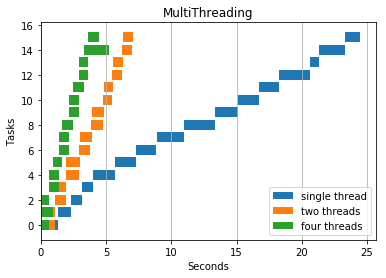

In [5]:
for entry in zip(counts, thread_labels):
    num_threads, label = entry
    visualize_runtimes(multithreading(download, urls, num_threads), label, MULTITHREADING_TITLE)
    

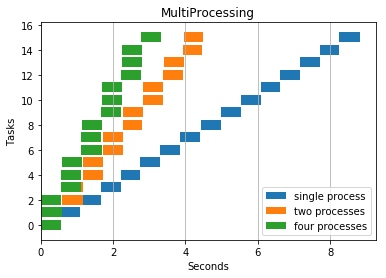

In [12]:
for entry in zip(counts, proc_labels):
    num_procs, label = entry
    visualize_runtimes(multiprocessing(download, urls, num_procs), label, MULTIPROCESSING_TITLE)
    

In [7]:
# IO Heavy

def io_heavy(text,base):
    start = time.time() - base
    f = open('output.txt', 'wt', encoding='utf-8')
    f.write(text)
    f.close()
    stop = time.time() - base
    return start,stop

N=12
TEXT = ''.join(random.choice(string.ascii_lowercase) for i in range(10**7))

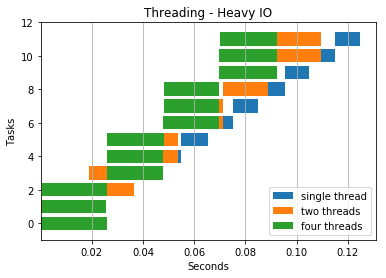

In [8]:
for entry in zip(counts, thread_labels):
    num_threads, label = entry
    visualize_runtimes(multithreading(io_heavy, [TEXT for i in range(N)], num_threads), label, "Threading - Heavy IO")
    
    

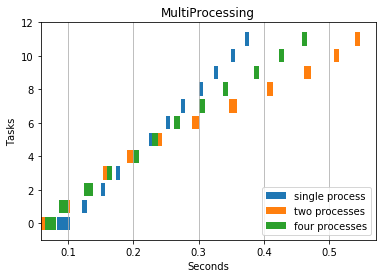

In [15]:
for i in zip(counts, proc_labels):
    num_procs, label = i
    visualize_runtimes(multiprocessing(io_heavy, [TEXT for i in range(N)], num_procs), label, MULTIPROCESSING_TITLE)
    


In [16]:
# Numpy

#Does not use parallel processing by default
#But will see speedups if multiprocessing used
#Because numpy sidesteps python's GIL
def addition(i, base):
    start = time.time() - base
    res = a + b
    stop = time.time() - base
    return start,stop

DIMS = 15000
N = 20
DIMS_ARR = [DIMS for i in range(N)]
a = np.random.rand(DIMS,DIMS)
b = np.random.rand(DIMS,DIMS)

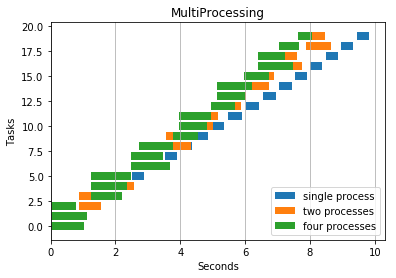

In [18]:
for entry in zip(counts, proc_labels):
    num_procs, label = entry
    visualize_runtimes(multithreading(addition, [i for i in range(N)], num_procs), label, MULTIPROCESSING_TITLE)
    

### When you are implementing this on your own:
    
It is important to note that only _some_ problems will see performance gains when using either multiprocessing or multithreading. If your program has not been written in a concurrent way, you will see no performance boost through using either of these two modules. In order to set yourself up for success follow this guidelines:

   1) Know whether to use multiprocessing or multithreading in the appropriate use cases.


   2) Minimize communication between processes/threads.


   3) Minimize shared memory (if using multiprocessing), if using shared objects between processes (dictionaries, lists, ints, strings, etc.) make sure that these objects are relatively small. 


   4) Utilize chunking where appropriate (passing chunks of tasks to each process, instead of individually. 


   5) Write your program steps to be run as independently as possible, or sometimes known as [embarassingly parallel](https://en.wikipedia.org/wiki/Embarrassingly_parallel)

### Questions?